# US Immigration data, Data pipeline
#### Project Summary
Create an ETL pipeline for I94 immigration, land temperatures, US demographics and airport datasets to form an analytics database on immigration events. A use case for this analytics database is to find immigration patterns to the US. For example, we could try to find answears to questions such as, do people from countries with warmer or cold climate immigrate to the US in large numbers?

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [5]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import *

In [6]:
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

## Step 1: Scope the Project and Gather Data

### Scope 
- use spark to load data to workspace.
- EDA for checking missing value.
- cleaning data based on EDA result.
- using spark to write parquet file

## Describe and Gather Data 
### I94 Immigration Data
This data comes from the US National Tourism and Trade Office. In the past all foreign visitors to the U.S. arriving via air or sea were required to complete paper Customs and Border Protection Form I-94 Arrival/Departure Record or Form I-94W Nonimmigrant Visa Waiver Arrival/Departure Record and this dataset comes from this forms.

This dataset forms the core of the data warehouse and the customer repository has a years worth of data for the year 2016 and the dataset is divided by month. For this project the data is in a folder located at ../../data/18-83510-I94-Data-2016/. Each months data is stored in an SAS binary database storage format sas7bdat. For this project we have chosen going to work with data for the month of April. However, the data extraction, transformation and loading utility functions have been designed to work with any month's worth of data.

In [7]:
immigration_file = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df = spark.read.format('com.github.saurfang.sas.spark').load(immigration_file)

In [8]:
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [9]:
immigration_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


### World Temperature Data
The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

In [10]:
land_temperature_file = '../../data2/GlobalLandTemperaturesByCity.csv'
land_temperature_df = spark.read.csv(land_temperature_file, header=True, inferSchema=True)

In [11]:
land_temperature_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [12]:
land_temperature_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


### U.S. City Demographic Data
This data comes from OpenSoft and contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Original data comes from the US Census Bureau's 2015 American Community Survey.

In [13]:
us_cities_demograghics_file = 'us-cities-demographics.csv'
us_cities_demograghics_df = spark.read.csv(us_cities_demograghics_file, sep = ';', header=True, inferSchema=True)

In [14]:
us_cities_demograghics_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [15]:
us_cities_demograghics_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


### Airport Code Table
This is a simple table of airport codes and corresponding cities.

In [17]:
airport_codes_file = 'airport-codes_csv.csv'
airport_codes_df = spark.read.csv(airport_codes_file, header=True, inferSchema=True)

In [18]:
airport_codes_df.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [19]:
airport_codes_df.limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


## Step 2: Explore and Assess the Data
### Exploratory Data Analysis and Cleaning Data

#### Visualize World Temperature Data missing values

In [16]:
total = immigration_df.count()
immigration_df_vis = immigration_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in immigration_df.columns]).toPandas()

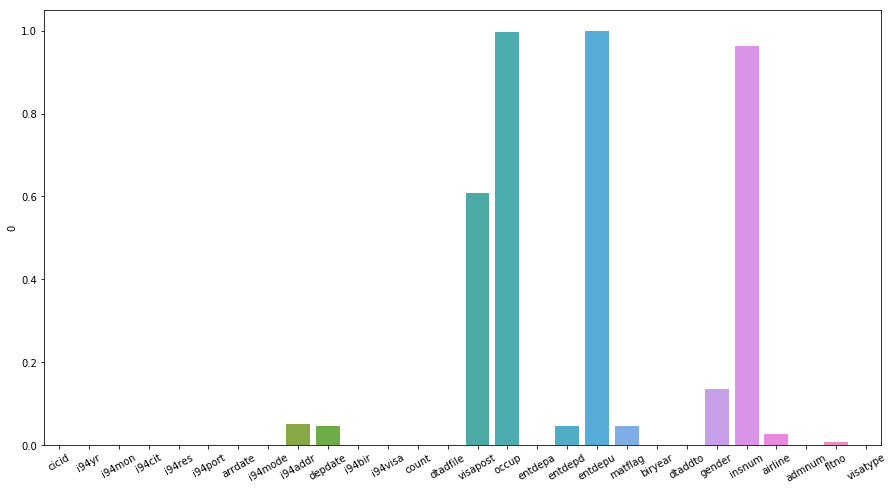

In [17]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=immigration_df_vis.columns, y=immigration_df_vis.iloc[0] / total)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

drop column that have more than 0.5 missing values and drop all NaN.

In [18]:
immigration_df = immigration_df.drop('visapost', 'occup', 'entdepu','insnum')
immigration_df = immigration_df.dropna(how='all')

#### Visualize I94 Immigration Data missing values

In [19]:
total = land_temperature_df.count()
land_temperature_df_vis = land_temperature_df.withColumn("dt",col("dt").cast(StringType()))
land_temperature_df_vis = land_temperature_df_vis.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in land_temperature_df_vis.columns]).toPandas()

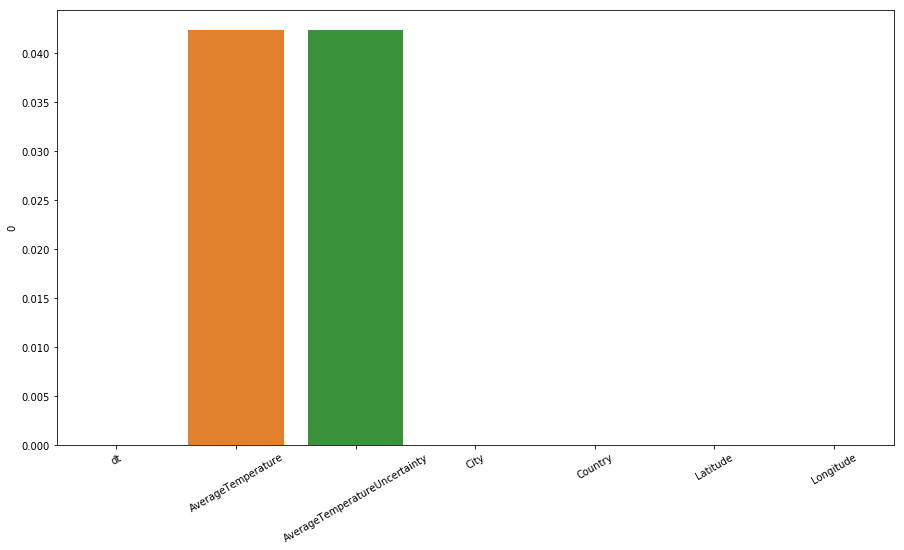

In [20]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=land_temperature_df_vis.columns, y=land_temperature_df_vis.iloc[0] / total)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

no column that have more than 0.5. just drop NaN.

In [21]:
land_temperature_df = land_temperature_df.dropna(how='all')

#### Visualize U.S. City Demographic Data missing values

In [22]:
total = us_cities_demograghics_df.count()
us_cities_demograghics_df_vis = us_cities_demograghics_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in us_cities_demograghics_df.columns]).toPandas()

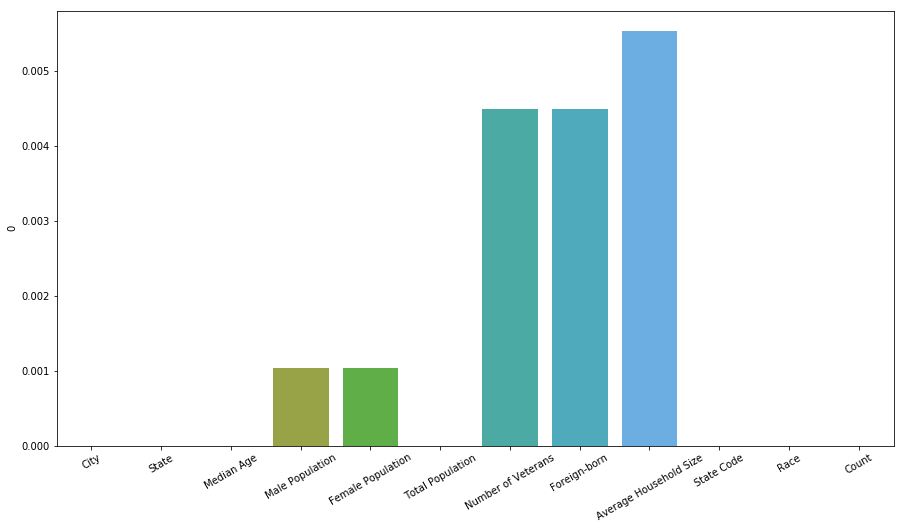

In [23]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=us_cities_demograghics_df_vis.columns, y=us_cities_demograghics_df_vis.iloc[0] / total)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

no column that have more than 0.5. just drop NaN.

In [24]:
us_cities_demograghics_df = us_cities_demograghics_df.dropna(how='all')

#### Visualize Airport Code Table missing values

In [25]:
total = airport_codes_df.count()
airport_codes_df_vis = airport_codes_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in airport_codes_df.columns]).toPandas()

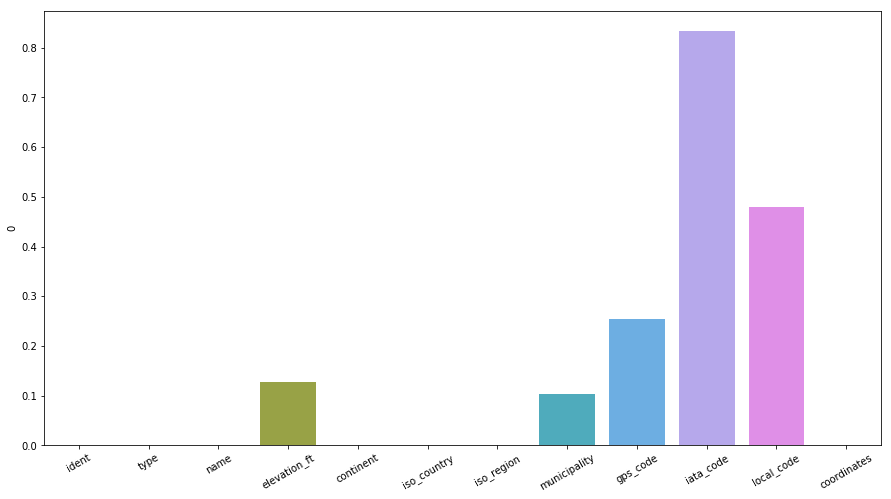

In [26]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=airport_codes_df_vis.columns, y=airport_codes_df_vis.iloc[0] / total)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

drop column that have more than 0.5 and drop all NaN.

In [27]:
airport_codes_df = airport_codes_df.drop('iata_code', 'local_code')
airport_codes_df = airport_codes_df.dropna(how='all')

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
<img src="images/datamodel.png">

#### 3.2 Mapping Out Data Pipelines
pipeline steps 
- load the datasets
- cleaning data, missing values
- transform raw data to our data models

### Step 4: Run Pipelines to Model the Data 
#### immigration fact table

In [29]:
get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)

In [30]:
output_data = '/tables'
immigration_fact= immigration_df.withColumn('arrdate', get_datetime(immigration_df.arrdate))

In [32]:
immigration_fact.write.parquet(output_data + "immigration_fact", mode="overwrite")

In [58]:
spark.read.parquet(output_data + "immigration_fact").limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepa,entdepd,matflag,biryear,dtaddto,gender,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,2016-04-30,1.0,CA,20582.0,...,G,O,M,1976.0,10292016,F,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,2016-04-30,1.0,NV,20591.0,...,G,O,M,1984.0,10292016,F,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,2016-04-30,1.0,WA,20582.0,...,G,O,M,1987.0,10292016,M,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,2016-04-30,1.0,WA,20588.0,...,G,O,M,1987.0,10292016,F,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,2016-04-30,1.0,WA,20588.0,...,G,O,M,1988.0,10292016,M,DL,9.495639e+10,00040,B1


#### immigration time table

In [34]:
immigration_time = immigration_df.select(['arrdate']).withColumn("arrdate", get_datetime(immigration_df.arrdate)).distinct()
    
# expand df by adding other calendar columns
immigration_time = immigration_time.withColumn('arrival_day', dayofmonth('arrdate'))
immigration_time = immigration_time.withColumn('arrival_week', weekofyear('arrdate'))
immigration_time = immigration_time.withColumn('arrival_month', month('arrdate'))
immigration_time = immigration_time.withColumn('arrival_year', year('arrdate'))
immigration_time = immigration_time.withColumn('arrival_weekday', dayofweek('arrdate'))

In [35]:
immigration_time.write.parquet(output_data + "immigration_time", mode="overwrite")

In [36]:
spark.read.parquet(output_data + "immigration_time").limit(5).toPandas()

,arrdate,arrival_day,arrival_week,arrival_month,arrival_year,arrival_weekday
0,2016-04-29,29,17,4,2016,6
1,2016-04-14,14,15,4,2016,5
2,2016-04-07,7,14,4,2016,5
3,2016-04-15,15,15,4,2016,6
4,2016-04-19,19,16,4,2016,3


#### airport table

In [37]:
get_state = udf(lambda x: x[3:] if x else None)

In [38]:
airport = airport_codes_df.where("iso_country = 'US'").withColumn('iso_region', get_state(airport_codes_df.iso_region))

In [39]:
airport.write.parquet(output_data + "airport", mode="overwrite")

In [40]:
spark.read.parquet(output_data + "airport").limit(5).toPandas()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,PA,Bensalem,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,KS,Leoti,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,AK,Anchor Point,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,AL,Harvest,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,AR,Newport,None,"-91.254898, 35.6087"


#### us demograghic table

In [41]:
us_demograghic = us_cities_demograghics_df.withColumnRenamed('Median Age','median_age') \
                                        .withColumnRenamed('Male Population', 'male_population') \
                                        .withColumnRenamed('Female Population', 'female_population') \
                                        .withColumnRenamed('Total Population', 'total_population') \
                                        .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
                                        .withColumnRenamed('Foreign-born', 'foreign_born') \
                                        .withColumnRenamed('Average Household Size', 'average_household_size') \
                                        .withColumnRenamed('State Code', 'state_code')

In [42]:
us_demograghic.write.parquet(output_data + "us_demograghic", mode="overwrite")

In [43]:
spark.read.parquet(output_data + "us_demograghic").limit(5).toPandas()

,City,State,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


#### land temperature table

In [44]:
upper = udf(lambda x: x.upper() if x else None)
mapper = pd.read_csv('i94res_mapping.csv', index_col=1)
mapping = udf(lambda x: float(mapper.loc[x].values[0]) if x in mapper.index else None)

In [45]:
land_temperature_modified = land_temperature_df.withColumn('Country', upper(land_temperature_df.Country)) 
land_temperature_modified = land_temperature_modified.withColumn('Country', mapping(land_temperature_modified.Country)) \
                                    .withColumnRenamed('Country', 'country_code') \
                                    .withColumnRenamed('AverageTemperature', 'average_temperature')
land_temperature_modified = land_temperature_modified.select('country_code', 'average_temperature')

In [46]:
land_temperature = land_temperature_modified.dropDuplicates(['country_code'])

In [49]:
land_temperature.write.parquet(output_data + "land_temperature", mode="overwrite")

In [50]:
spark.read.parquet(output_data + "land_temperature").limit(5).toPandas()

,country_code,average_temperature
0,158.0,13.221
1,204.0,26.193
2,163.0,-5.915
3,140.0,4.112
4,504.0,27.353


#### 4.2 Data Quality Checks
The data quality checks ensures that the ETL has created fact and dimension tables with adequate records

In [20]:
def quality_checks(table):
    total = table.count()
    if total > 0:
        print(f'Data quality checks passed with {total} records.')
    else:
        print(f'Data quality checks failed with {total} record.')

In [63]:
tables = [immigration_fact, immigration_time, airport, us_demograghic, land_temperature]

for table in tables:
    quality_checks(table)

Data quality checks passed with 3096313 records.
Data quality checks passed with 30 records.
Data quality checks passed with 22757 records.
Data quality checks passed with 2891 records.
Data quality checks passed with 146 records.


## 4.3 Data dictionary 

### Immigration Fact Table



| Field Name | Description                                   |
|------------|-----------------------------------------------|
| cicid      | Unique cicid                                  |
| arrdate    | Arrival date at USA                           |
| i94addr    | USA state of arrival                          |
| i94res     | Country code                                  |
| i94yr      | 4 digit year                                  |
| i94mon     | Numeric month                                 |
| i94cit     | City code                                     |
| i94port    | Port of admission                             |
| i94mode    | Mode of transportation                        |
| depdate    | Departure date from the USA                   |
| i94bir     | Age of respondent                             |
| i94visa    | Visa codes                                    |
| count      | Statistics summary                            |
| dtadfile   | Date field character - Date add tp I-94 files |
| entdepa    | Arrival flag                                  |
| entdepd    | Departure flag                                |
| matflag    | Match flag                                    |
| biryear    | 4 digit year of birth                         |
| dtaddto    | Date field character - Date admitted to US    |
| gender     | Non-immigrant sex                             |
| airline    | Public air transportation name                |
| admnum     | Admission number                              |
| fltno      | Flight number                                 |
| visatype   | Class of admission                            |

### Immigration Time Dimension Table



| Field Name | Description                                   |
|------------|-----------------------------------------------|
| arrdate    | Unique arrival date                                  |
| arrival_year    | Arrival year into US                          |
| arrival_month    | Arrival Month                         |
| arrival_day     | Arrival Day                                  |
| arrival_week      | Arrival Week                                 |
| arrival_weekday     | Arrival WeekDay                              |

### Airport Dimension Table



| Field Name | Description                                   |
|------------|-----------------------------------------------|
| ident    | Unique identifier                                  |
| iso_region    | ISO code for the region of the airport                          |
| type    | Airport type                        |
| name     | Airport name                                  |
| elevator_ft      | Altitude of the airport                                 |
| continent     | Continent                              |
| municipality     | City where the airport is located                              |
| gps_code     | GPS code of the airport                              |
| coordinates     | GPS coordinates of the airport                            |

### US Demographic Dimension Table



| Field Name | Description                                   |
|------------|-----------------------------------------------|
| state_code    | US state code of the city                                |
| city    | Name of the city                          |
| state    | US state of the city                       |
| median_age     | The median of the age of the population                              |
| male_population      | Number of the male population                            |
| female_population     | Number of the female population                              |
| total_population     | Number of the total population                             |
| num_veterans     | Number of veterans living in the city                              |
| foreign_born     | Number of residents of the city that were not born in the city                           |
| average_household_size     | Average size of the houses in the city                         |
| race     | Race class                            |
| count     | 	Number of individual of each race                           |

### Land Temperature Dimension Table



| Field Name | Description                                   |
|------------|-----------------------------------------------|
| country_code    | Country code                                |
| average_temperature    | 	Average temperature of the city in a given date                          |

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.